In [1]:
# change to parent directory to import module
%cd ..

/home/achilleas/projects/osbuild/metrics


In [2]:
# imports, function definitions, and global settings
import json
import pandas
import report

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import ibmetrics as ib

from datetime import datetime, timedelta

from IPython.display import display, Markdown


def mdprint(msg):
    display(Markdown(msg))
    
matplotlib.rc('font', size=24)

In [3]:
# read data
builds = report.read_file("./data/dump-2022-12-05.log")
users = pandas.read_json("./data/userinfo.json", dtype=False)
with open("./data/userfilter.txt", encoding="utf-8") as filterfile:
    user_filter = filterfile.read().split("\n")

mdprint(f"Read {len(builds)} records")

Using cached pickle file at /home/achilleas/.cache/osbuild-metrics/dump-2022-12-05.pkl


Read 7872 records

In [4]:
# filtering: remove builds before GA
ga_date = datetime(2022, 5, 4)
ga_idxs = builds["created_at"] >= ga_date
builds = builds.loc[ga_idxs]
mdprint(f"Using {len(builds)} records (since GA)")

# filtering: remove internal users
builds = ib.data.filter_users(builds, users, user_filter)
mdprint(f"Using {len(builds)} records (after filtering)")

Using 6038 records (since GA)

Using 2436 records (after filtering)

In [5]:
summary = ib.metrics.make_summary(builds)
mdprint(ib.metrics.summarise(summary))

Summary
=======

Period: 2022-05-04 14:11:47.137615 - 2022-12-04 21:48:32.648686

- Total builds: 2436
- Number of users: 883
- Builds with packages: 1426
- Builds with filesystem customizations: 848
- Builds with custom repos: 57

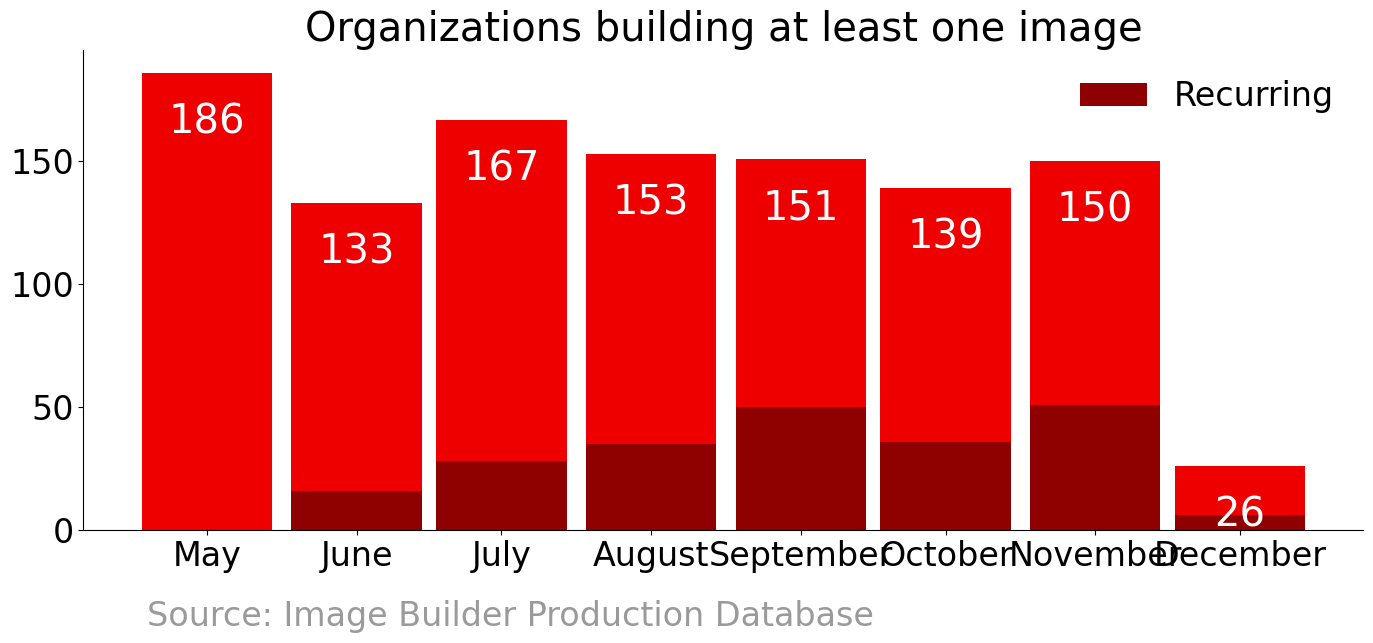

In [6]:
fig = plt.figure()
new_users_ax = fig.add_axes([0, 0, 2, 1])
ib.plot.monthly_users_stacked(builds, new_users_ax)

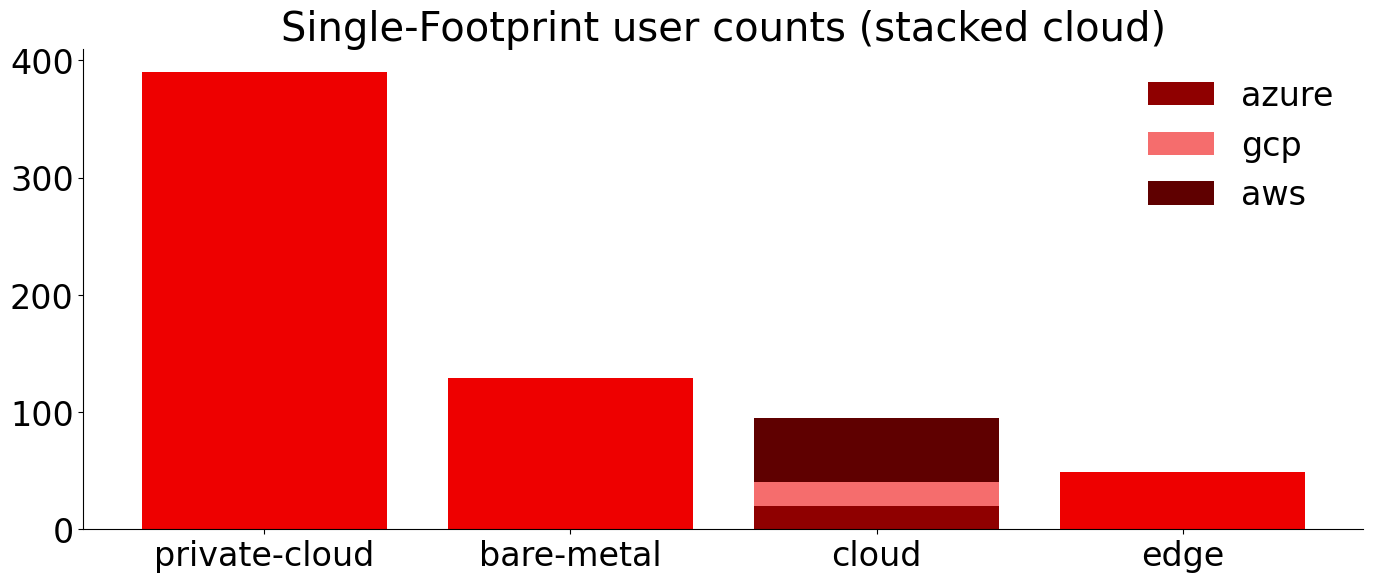

In [7]:
# distribution of single-footprint users (stacked cloud)
# it's a little hacky, but that's okay for this notebook
fig = plt.figure()
ax = plt.axes([0, 0, 2, 1])

sfp_users = ib.metrics.single_footprint_users(builds)
fp_counts = sfp_users["footprint"].value_counts()
# ax.bar(fp_counts.index, fp_counts.values)

bottom = 0
clouds = {"aws", "azure", "gcp"}
cloud_sum = sum(v if k in clouds else 0 for k, v in fp_counts.items())

cloud_grouped_feet = fp_counts.copy()
cloud_grouped_feet["cloud"] = cloud_sum
for cloud in clouds:
    del cloud_grouped_feet[cloud]

cloud_grouped_feet.sort_values(ascending=False, inplace=True)
ax.bar(cloud_grouped_feet.index, cloud_grouped_feet.values)  # plot with grouped cloud to get them in order (sorted)
for ft in cloud_grouped_feet.items():
    if ft[0] == "cloud":
        continue

# # draw over cloud bar with breakdown values of individual clouds
for cld in clouds:
    ax.bar("cloud", fp_counts[cld], bottom=bottom, label=cld)
    bottom += fp_counts[cld]


ax.set_title("Single-Footprint user counts (stacked cloud)")
ax.legend()